# Attention-based CNN for Facial Expression Recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip

 86% 246M/285M [00:00<00:00, 445MB/s]
100% 285M/285M [00:00<00:00, 475MB/s]


In [5]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import wandb
from datetime import datetime
from tqdm import tqdm


In [29]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
CONFIG = {
    'model_name': 'attention_cnn_v3',
    'batch_size': 64,
    'learning_rate': 0.0005,
    'epochs': 40,
    'image_size': 48,
    'num_classes': 7,
    'random_seed': 42,
    'weight_decay': 1e-4,
    'dropout_rate': 0.5,
    'attention_heads': 4  # Number of attention heads
}

# Set random seeds for reproducibility
torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

torch.backends.cudnn.benchmark = True

# Use mixed precision training
scaler = torch.cuda.amp.GradScaler()


Using device: cuda


<ipython-input-29-87a88fb088a7>:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [26]:

# Initialize Weights & Biases for experiment tracking
wandb.init(
    project="facial-expression-recognition",
    name=f"{CONFIG['model_name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    config=CONFIG,
    job_type="training"
)

## Dataset and Data Loading

In [8]:

class FERDataset(Dataset):
    def __init__(self, dataframe, indices, transform=None):
        self.data = dataframe.iloc[indices].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        image = np.array(pixels.split(), dtype=np.uint8).reshape(48, 48)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension

        if self.transform:
            image = self.transform(image)

        label = int(self.data.iloc[idx]['emotion'])
        return image, label


## Attention Mechanisms

In [9]:

class SpatialAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(SpatialAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * out

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = (avg_out + max_out).view(b, c, 1, 1)
        return x * out

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, in_channels, reduction_ratio=8):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_att = SpatialAttention(in_channels, reduction_ratio)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x


In [10]:

class AttentionCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(AttentionCNN, self).__init__()

        # Initial conv block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Attention after first block
        self.att1 = CBAM(32)

        # Second conv block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Attention after second block
        self.att2 = CBAM(64)

        # Third conv block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Attention after third block
        self.att3 = CBAM(128)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.att1(x)

        # Second block
        x = self.conv2(x)
        x = self.att2(x)

        # Third block
        x = self.conv3(x)
        x = self.att3(x)

        # Global average pooling and flatten
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc(x)

        return x


In [11]:
class LightAttentionCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super().__init__()
        # Initial conv block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Attention after first block
        self.att1 = CBAM(16)

        # Second conv block
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Attention after second block
        self.att2 = CBAM(32)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # First convolutional block + attention
        x = self.conv1(x)
        x = self.att1(x)

        # Second convolutional block + attention
        x = self.conv2(x)
        x = self.att2(x)

        # Global average pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 32)

        # Fully connected layers
        x = self.fc(x)

        return x


In [12]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    best_val_acc = 0.1

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix({
                'loss': running_loss / total,
                'acc': 100. * correct / total
            })

            # In your training loop:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Log training metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct / len(train_loader.dataset)

        wandb.log({
            'train/loss': epoch_loss,
            'train/accuracy': epoch_acc,
            'epoch': epoch
        })

        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        # Log validation metrics
        wandb.log({
            'val/loss': val_loss,
            'val/accuracy': val_acc,
            'epoch': epoch
        })

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_attention_cnn.pth')
            print(f'Model saved with validation accuracy: {val_acc:.2f}%')

    return model

In [27]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(inputs.cpu())  # Keep the actual image tensors

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)

    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 🧩 Log confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.close()

    # 📜 Log classification report
    class_report = classification_report(all_labels, all_preds, output_dict=True)
    wandb.log({"classification_report": class_report})

    return avg_loss, accuracy


In [14]:
# Load data
print("Loading data...")
train_df = pd.read_csv('train.csv')

# Load train/val indices (assuming they're saved from previous experiments)
try:
    train_indices = np.load('../train_indices.npy')
    val_indices = np.load('../val_indices.npy')
except FileNotFoundError:
    # If indices files don't exist, create them
    from sklearn.model_selection import train_test_split
    train_indices, val_indices = train_test_split(
        np.arange(len(train_df)),
        test_size=0.2,
        random_state=CONFIG['random_seed'],
        stratify=train_df['emotion']
    )
    np.save('../train_indices.npy', train_indices)
    np.save('../val_indices.npy', val_indices)

# Create datasets
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = FERDataset(train_df, train_indices, transform=train_transform)
val_dataset = FERDataset(train_df, val_indices, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                        shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'],
                        shuffle=False, num_workers=4, pin_memory=True)


Loading data...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [30]:

# Initialize model, loss function, and optimizer
model = AttentionCNN(num_classes=CONFIG['num_classes'],
                    dropout_rate=CONFIG['dropout_rate']).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                        lr=CONFIG['learning_rate'],
                        weight_decay=CONFIG['weight_decay'])

# Log model architecture to wandb
wandb.watch(model, log='all')


In [31]:

# Train the model
print("Starting training...")
model = train_model(model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=CONFIG['epochs'])


Starting training...


Epoch 1/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/40 [Train]:   0%|          | 0/359 [00:01<?, ?it/s, loss=2.09, acc=14.1]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 20.08it/s]


Validation Loss: 1.4710, Accuracy: 42.89%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved with validation accuracy: 42.89%


Epoch 2/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.32, acc=51.6]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 15.39it/s]


Validation Loss: 1.3240, Accuracy: 49.22%
Model saved with validation accuracy: 49.22%


Epoch 3/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.2, acc=59.4]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.84it/s]


Validation Loss: 1.1751, Accuracy: 54.84%
Model saved with validation accuracy: 54.84%


Epoch 4/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.2, acc=57.8]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 21.33it/s]


Validation Loss: 1.1320, Accuracy: 57.54%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved with validation accuracy: 57.54%


Epoch 5/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.13, acc=54.7]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 17.34it/s]


Validation Loss: 1.0988, Accuracy: 57.87%
Model saved with validation accuracy: 57.87%


Epoch 6/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.18, acc=54.7]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.94it/s]


Validation Loss: 1.0827, Accuracy: 58.90%
Model saved with validation accuracy: 58.90%


Epoch 7/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.04, acc=60.9]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 18.81it/s]


Validation Loss: 1.0760, Accuracy: 58.81%


Epoch 8/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.04, acc=60.9]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 22.39it/s]


Validation Loss: 1.0081, Accuracy: 61.32%
Model saved with validation accuracy: 61.32%


Epoch 9/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.894, acc=70.3]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.78it/s]


Validation Loss: 1.0847, Accuracy: 59.80%


Epoch 10/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.14, acc=54.7]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 15.26it/s]


Validation Loss: 1.0106, Accuracy: 61.95%
Model saved with validation accuracy: 61.95%


Epoch 11/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.958, acc=62.5]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.86it/s]


Validation Loss: 1.1128, Accuracy: 59.93%


Epoch 12/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=1.07, acc=60.9]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.43it/s]


Validation Loss: 1.1117, Accuracy: 58.83%


Epoch 13/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.708, acc=73.4]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 16.10it/s]


Validation Loss: 1.0307, Accuracy: 61.79%


Epoch 14/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.785, acc=75]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.70it/s]


Validation Loss: 0.9828, Accuracy: 63.44%
Model saved with validation accuracy: 63.44%


Epoch 15/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.873, acc=71.9]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.61it/s]


Validation Loss: 1.0156, Accuracy: 62.16%


Epoch 16/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.951, acc=62.5]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 19.94it/s]


Validation Loss: 1.0857, Accuracy: 60.19%


Epoch 17/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.667, acc=76.6]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.07it/s]


Validation Loss: 0.9842, Accuracy: 63.44%


Epoch 18/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.763, acc=70.3]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 15.24it/s]


Validation Loss: 1.0448, Accuracy: 62.52%


Epoch 19/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.909, acc=70.3]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.77it/s]


Validation Loss: 1.0365, Accuracy: 62.63%


Epoch 20/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.878, acc=67.2]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 18.92it/s]


Validation Loss: 1.0453, Accuracy: 62.49%


Epoch 21/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.84, acc=65.6]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.71it/s]


Validation Loss: 1.0316, Accuracy: 61.89%


Epoch 22/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.731, acc=73.4]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.08it/s]


Validation Loss: 1.0470, Accuracy: 63.86%
Model saved with validation accuracy: 63.86%


Epoch 23/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.893, acc=67.2]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 16.41it/s]


Validation Loss: 1.0541, Accuracy: 62.33%


Epoch 24/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.629, acc=79.7]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.11it/s]


Validation Loss: 1.0242, Accuracy: 63.57%


Epoch 25/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.573, acc=75]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 21.92it/s]


Validation Loss: 1.0360, Accuracy: 63.20%


Epoch 26/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 26/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.572, acc=79.7]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 18.56it/s]


Validation Loss: 1.1016, Accuracy: 61.93%


Epoch 27/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 27/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.632, acc=76.6]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.06it/s]


Validation Loss: 1.0348, Accuracy: 64.26%
Model saved with validation accuracy: 64.26%


Epoch 28/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 28/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.955, acc=68.8]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 16.09it/s]


Validation Loss: 1.0340, Accuracy: 64.59%
Model saved with validation accuracy: 64.59%


Epoch 29/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 29/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.736, acc=65.6]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.05it/s]


Validation Loss: 1.1444, Accuracy: 62.31%


Epoch 30/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 30/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.668, acc=73.4]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.12it/s]


Validation Loss: 1.2187, Accuracy: 59.93%


Epoch 31/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 31/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.644, acc=76.6]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 18.20it/s]


Validation Loss: 1.0875, Accuracy: 62.64%


Epoch 32/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 32/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.572, acc=79.7]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.80it/s]


Validation Loss: 1.0599, Accuracy: 63.93%


Epoch 33/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 33/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.551, acc=82.8]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 15.39it/s]


Validation Loss: 1.0764, Accuracy: 63.38%


Epoch 34/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 34/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.682, acc=73.4]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 19.43it/s]


Validation Loss: 1.0912, Accuracy: 64.51%


Epoch 35/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 35/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.443, acc=85.9]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.63it/s]


Validation Loss: 1.1303, Accuracy: 63.34%


Epoch 36/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 36/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.74, acc=73.4]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 16.42it/s]


Validation Loss: 1.1516, Accuracy: 62.78%


Epoch 37/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 37/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.462, acc=84.4]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 18.52it/s]


Validation Loss: 1.0699, Accuracy: 64.82%
Model saved with validation accuracy: 64.82%


Epoch 38/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 38/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.515, acc=78.1]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 22.24it/s]


Validation Loss: 1.1225, Accuracy: 64.44%


Epoch 39/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 39/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.496, acc=81.2]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 22.00it/s]


Validation Loss: 1.1336, Accuracy: 64.11%


Epoch 40/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 40/40 [Train]:   0%|          | 0/359 [00:00<?, ?it/s, loss=0.713, acc=70.3]<ipython-input-12-aa2d96ed0114>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 90/90 [00:05<00:00, 15.02it/s]


Validation Loss: 1.1649, Accuracy: 63.62%


Final evaluation...


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 90/90 [00:04<00:00, 21.67it/s]


Validation Loss: 1.1649, Accuracy: 63.62%


Error: You must call wandb.init() before wandb.log()

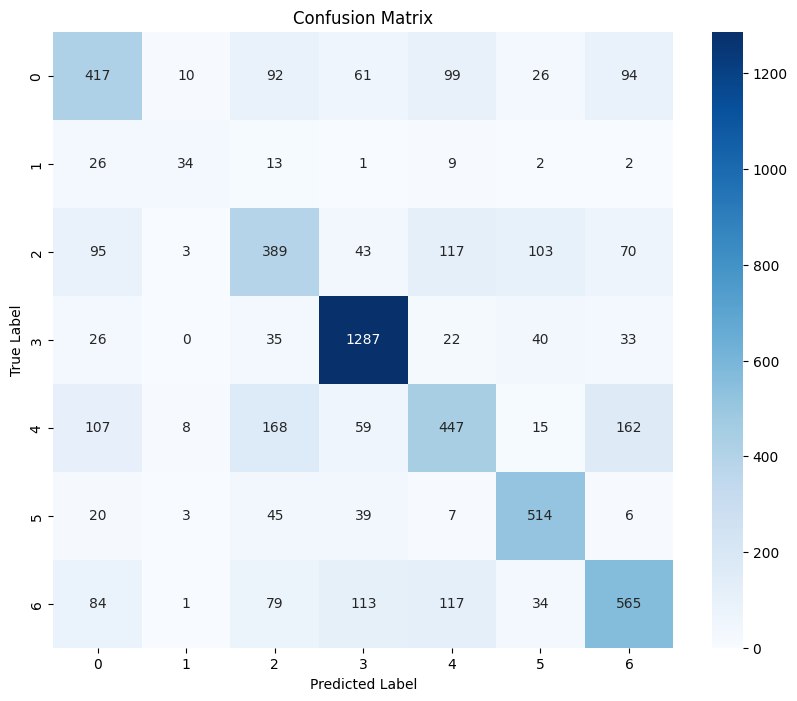

In [33]:
# Final evaluation
print("Final evaluation...")
evaluate_model(model, val_loader, criterion)

# Save the final model
torch.save(model.state_dict(), 'final_attention_cnn.pth')
wandb.save('*.pth')

print("Training completed!")

wandb.finish()